# Import packages and data

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import fmin
import torch
import os, glob

from indentation.indentationset import IndentationSet
from indentation.processing.find_contact import findContact_minimum, findContact_blackMagic, findContact_blackMagic_CNN
from indentation.processing.signal import do_nothing, crop_afm_temp, crop_start, crop_end
from indentation.processing.calculate_parameters import parameter_youngs_modulus, parameter_defelection_sensitivity
from indentation.processing.plotting import plot_curve_parameters_bar, plot_instance_parameters_bar, plot_mean_force_curves
from indentation.ml.models import ConvClassifier_1, ConvClassifier_2

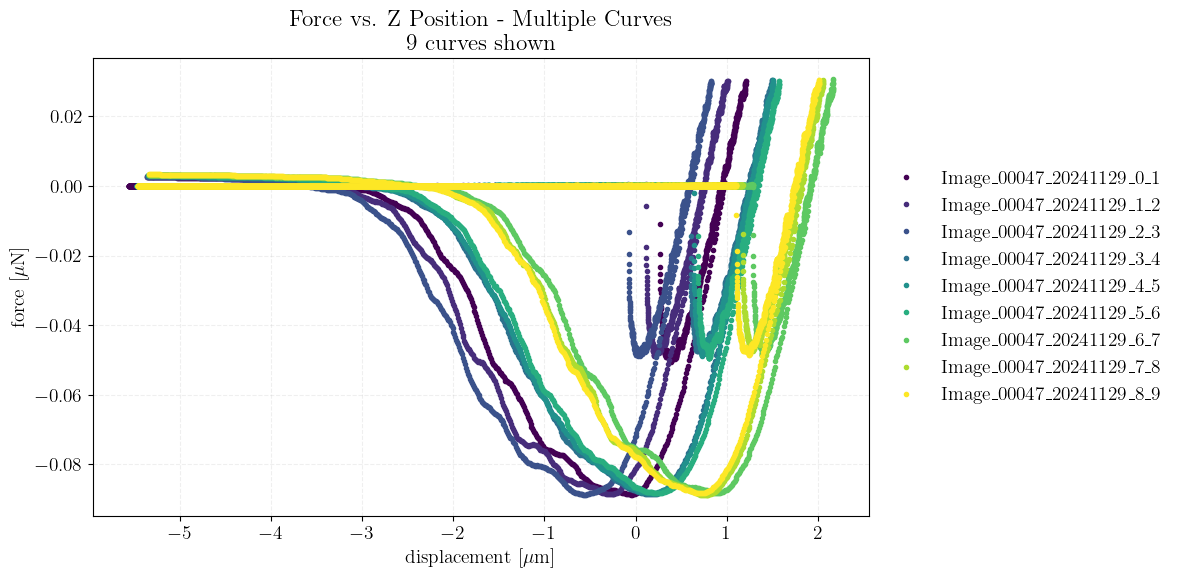

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [15]:
paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_29\afm_pdms35t1_pbs_no5\*.txt")

afm = IndentationSet(paths, exp_type="afm")

afm.plot_all(linestyle="")

# Processing data

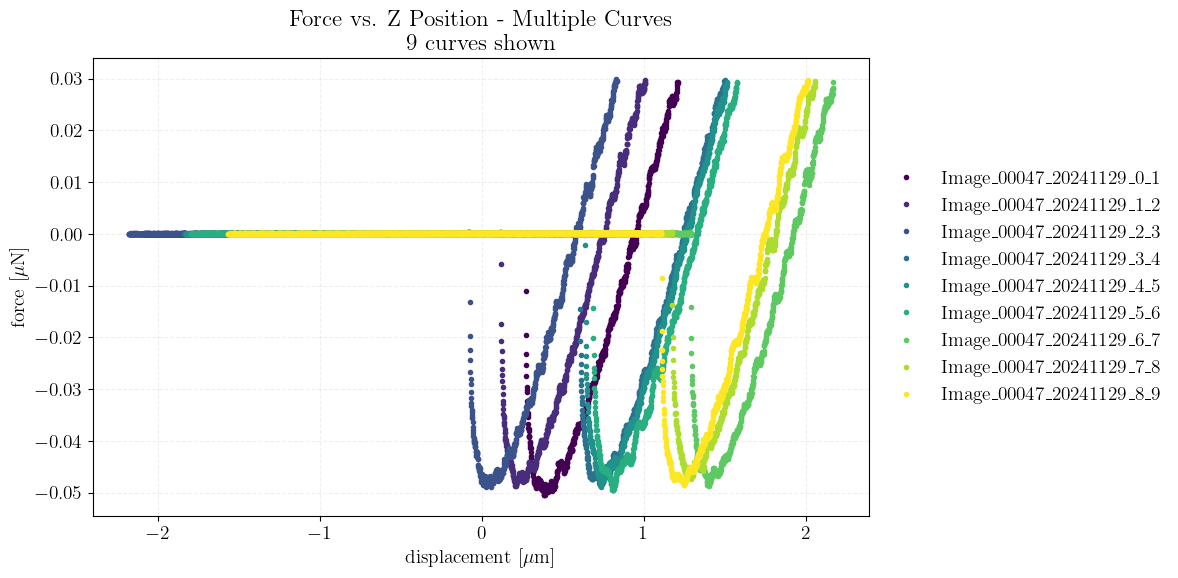

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [16]:
processing_pl = [crop_afm_temp]

afm.process_raw(processing_pl)
afm.plot_all(linestyle="")

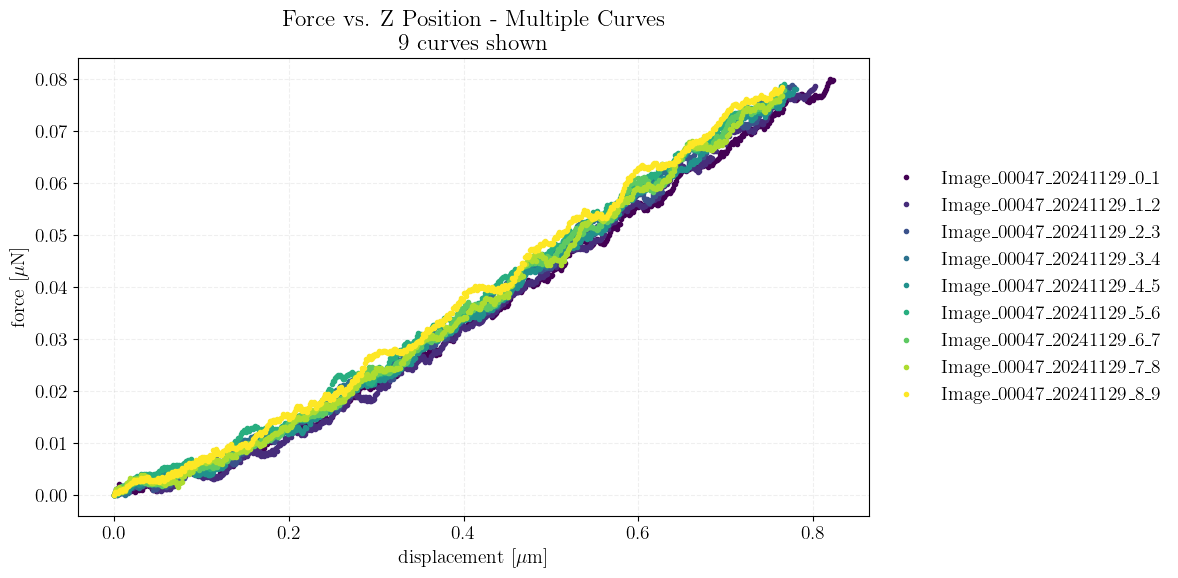

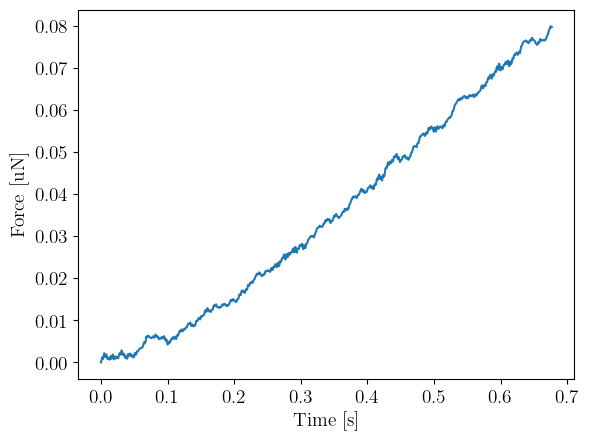

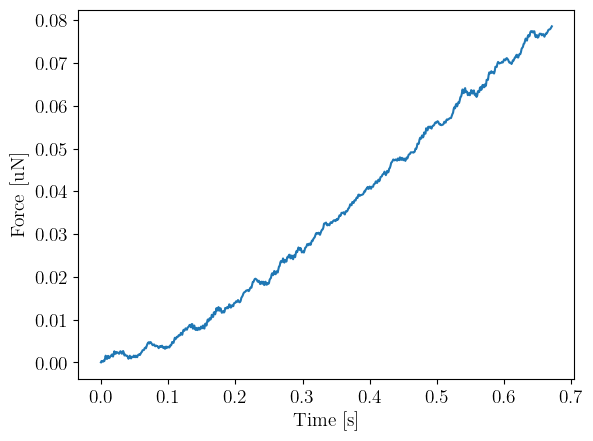

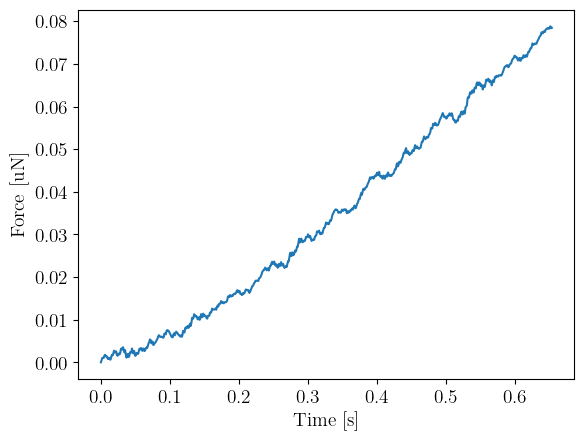

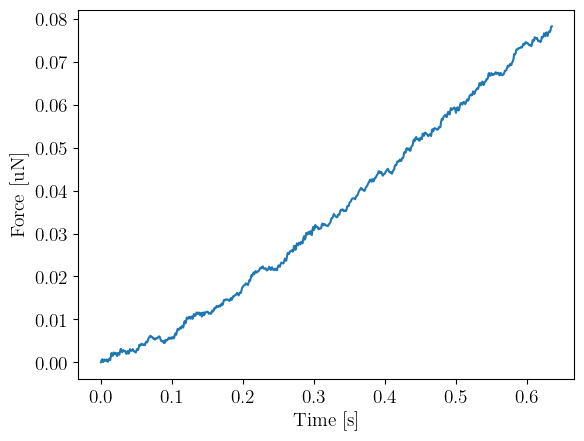

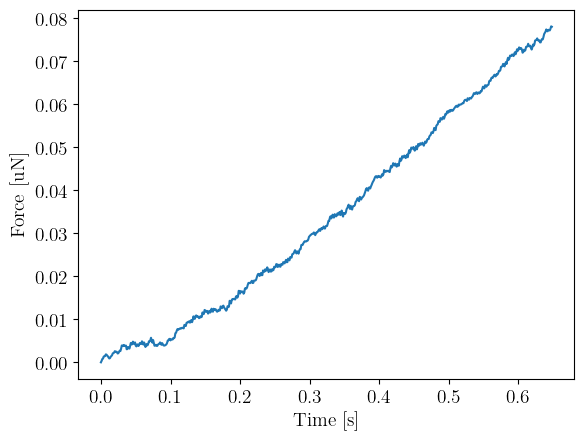

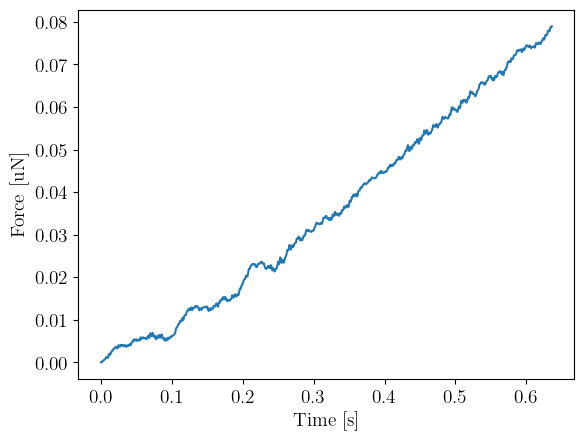

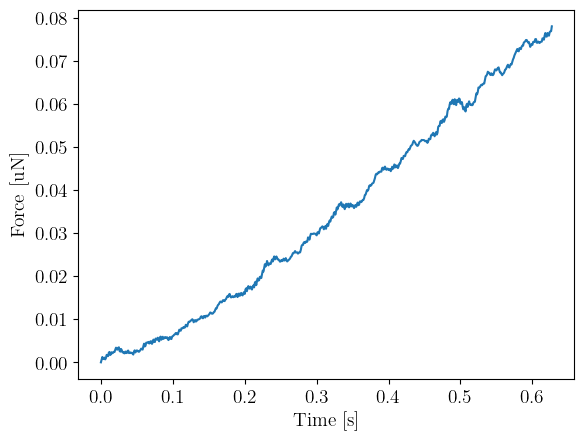

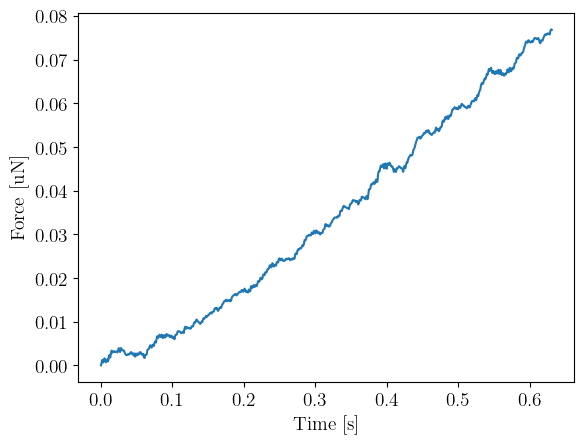

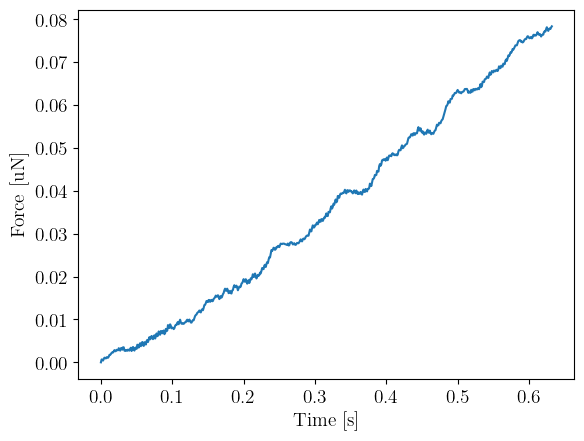

In [17]:
processing_pl = [crop_afm_temp, findContact_minimum]

afm.process_raw(processing_pl)
afm.plot_all(linestyle="")

f_s = 1000 # sampling rate [Hz]

for i in range(0, 9):
    n = len(afm.data[i]["processed"]["force"])
    time = np.linspace(0, n-1, n) / f_s

    # fig = px.scatter(x=time, y=afm.data[i]["processed"]["force"])
    # fig.show()
    
    plt.figure()
    plt.plot(time, afm.data[i]["processed"]["force"])
    plt.xlabel("Time [s]")
    plt.ylabel("Force [uN]")
    plt.show()

#plt.show()

Mean and std: 32.10356523150962 0.9566389606521188


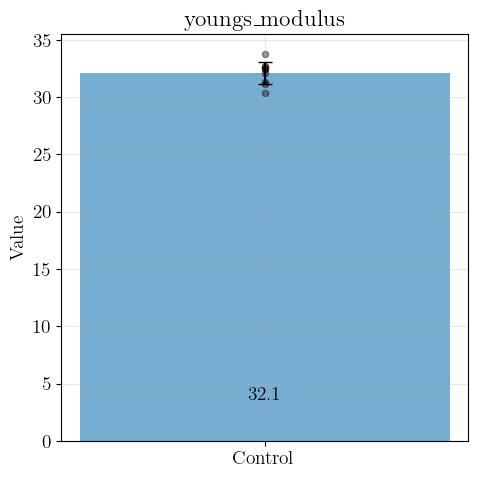

In [7]:
function_arguments = dict(radius=5, nu=0.5, cutoff=10, keyname="youngs_modulus")
afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_curve_parameters_bar(afm,
                         parameter_names=['youngs_modulus'],
                         labels=['Control'],
                         figsize=(5,5))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 60
31628.030315041542


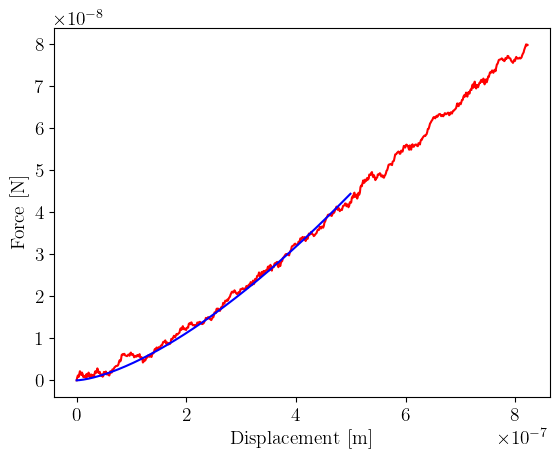

In [12]:
def hertzian(E, R, nu, z):
    hertz_F = 4.0 / 3.0 * E * np.sqrt(R) / (1 - nu*nu) * np.power(z, 3.0/2.0)
    
    return hertz_F

def sse(param, R, nu, F, z, cutoff):
    E = param
    ix = np.where(z > cutoff * R)[0]

    if(len(ix) == 0):
        ix = len(F) - 1
    else:
        ix = ix[0]

    force = F[:ix]
    disp_z = z[:ix]
    
    hertz_F = hertzian(E, R, nu, disp_z)

    sse_value = np.sum((force-hertz_F)**2.0)

    return sse_value

initial_guess = 50e3
R = 5 / 1e6
nu = 0.5
F = afm.data[0]["processed"]["force"] / 1e6
z = -afm.data[0]["processed"]["z"] / 1e6
cutoff = 0.10
result = fmin(sse, initial_guess, args=(R, nu, F, z, cutoff))
print(result[0])

ix = np.where(z > cutoff * R)[0]

if(len(ix) == 0):
    ix = len(F) - 1
else:
    ix = ix[0]
    
hertz_fit = hertzian(result[0], R, nu, z[:ix])

plt.figure()
plt.plot(z, F, 'r-')
plt.plot(z[:ix], hertz_fit, 'b-')
plt.xlabel("Displacement [m]")
plt.ylabel("Force [N]")
plt.show()

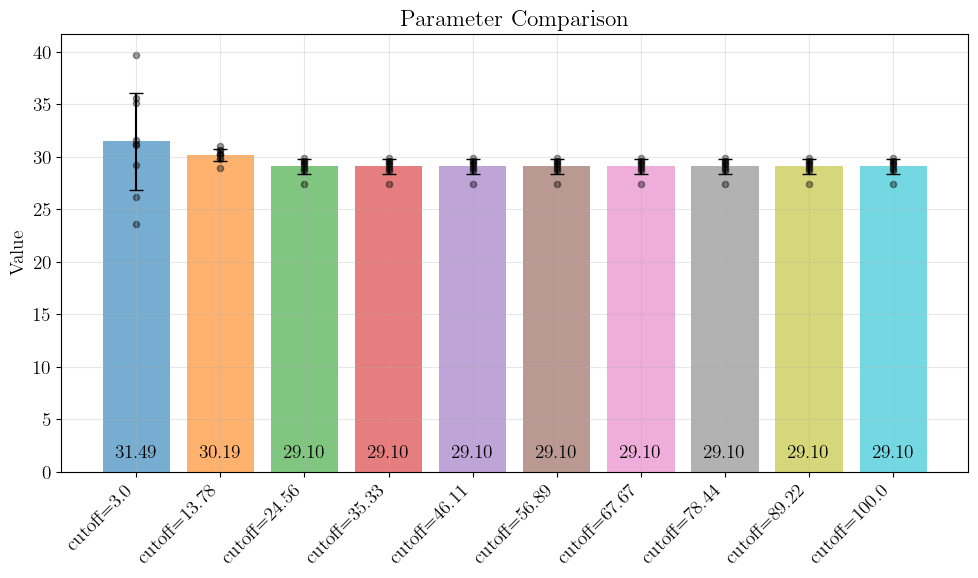

In [9]:
cutoffs = np.linspace(3, 100, 10)

for cutoff in cutoffs:
    function_arguments = dict(radius=5, nu=0.5, cutoff=cutoff, keyname="cutoff="+str(np.round(cutoff, 2)))
    afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_instance_parameters_bar(afm,
                         parameter_names=[*["cutoff="+str(np.round(cutoff, 2)) for cutoff in cutoffs]],
                         figsize=(10,6))